# Sprint 2 Stand Up

Short summary of this week's checkpoints.

In [2]:
import pandas as pd
import numpy as np
import os

# Set working directory
if not "/data/tables" in os.getcwd():
    os.chdir("../data/tables")

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType

%matplotlib inline

    
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.broadcastTimeout", -1)
    .getOrCreate()
)

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/

Using Python version 3.7.4 (default, Aug 13 2019 15:17:50)
Spark context Web UI available at http://172.16.29.12:4040
Spark context available as 'sc' (master = local[*], app id = local-1662576436399).
SparkSession available as 'spark'.


### Able to map all transactions data to consumer data

In [5]:
consumer = spark.read.option("delimiter", "|").csv('tbl_consumer.csv', header = True)
transaction = spark.read.parquet("transactions_20210828_20220227_snapshot/")
merchant = spark.read.parquet("tbl_merchants.parquet")
user_detail = spark.read.parquet("consumer_user_details.parquet")

In [6]:
consumer_id = consumer.toPandas()['consumer_id'].unique()
consumer_user_id = set(user_detail.toPandas()['user_id'].unique())
transaction_consumer_id = set(transaction.select('user_id').toPandas()['user_id'].unique())

In [7]:
# No consumer id in transaction data that cannot be found in the consumer dataset
transaction_consumer_id - consumer_user_id

set()

### Found missing merchant abn data in transactions

In [9]:
transaction_merchant_abn = set(transaction.select('merchant_abn').toPandas()['merchant_abn'].unique())
merchant_abn = set(merchant.toPandas()['merchant_abn'].unique())

In [19]:
missing_merchants = len(transaction_merchant_abn) - len(transaction_merchant_abn.intersection(merchant_abn))
print(f"Number of missing merchants data: {missing_merchants} ({(missing_merchants/len(transaction_merchant_abn)*100):.2f}%)")

Number of missing merchants data: 381 (8.70%)


### Solution (Temporary) - Discard their transaction records as we do not have crucial information such as Revenue Level and Take Rate

### Post Codes Discrepancies When Joining with ABS Datasets

In [20]:
postcodes = []

directory = os.getcwd() + '/POA/AUS/'
for root,dirs,files in os.walk(directory):
    for file in files:
        if file.endswith(".csv"):
            df = pd.read_csv(directory+file)
            poa = df['POA_CODE_2021'].apply(lambda x:int(x[3:])).to_list()
            postcodes += poa
            
postcodes = set(postcodes)


In [21]:
# Check available postcodes with the consumer data postcodes
consumer = consumer.withColumn("postcode", consumer["postcode"].cast(IntegerType()))

In [22]:
print("ABS Dataset:")
print(f"\tNumber of distinct postcodes: {len(postcodes)}\n\tPostcode range: {min(postcodes)} - {max(postcodes)}")
print("\nConsumer Dataset:")
print(f"\tNumber of distinct postcodes: {consumer.select('postcode').distinct().count()}",
      f"\n\tPostcode range: {consumer.agg({'postcode': 'min'}).collect()[0]['min(postcode)']} - {consumer.agg({'postcode': 'max'}).collect()[0]['max(postcode)']}")
unmatched_postcodes = consumer.where(~F.col('postcode').isin(postcodes)).count()
print(f"\nUnmatched Postcodes:\n\tNumber of unmatched postcodes: {unmatched_postcodes} out of {consumer.count()}")
print(f"\t% unmatched postcodes in consumer dataset: {(unmatched_postcodes/consumer.count())*100:.2f}%")


ABS Dataset:
	Number of distinct postcodes: 2643
	Postcode range: 800 - 9797

Consumer Dataset:
	Number of distinct postcodes: 3167 
	Postcode range: 200 - 9999

Unmatched Postcodes:
	Number of unmatched postcodes: 83181 out of 499999
	% unmatched postcodes in consumer dataset: 16.64%


### Solution - Reducing Granularity by Grouping based on SA2 Codes

In [23]:
import pandas as pd
import io
import requests

def read_url_data(url, data_format='csv'):
    
    content = requests.get(url).content
    
    if data_format == 'xlsx':
        return pd.read_excel(content)
        
    else:
        return pd.read_csv(io.StringIO(content.decode('utf-8')))




In [24]:
sa2_data = read_url_data("https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/allocation-files/SA2_2021_AUST.xlsx", 'xlsx')
postcode_database = read_url_data("https://www.matthewproctor.com/Content/postcodes/australian_postcodes.csv", "csv")


In [35]:
invalid_postcodes = consumer.where(~(F.col('postcode').isin(postcode_database['postcode'].unique().tolist())))

In [36]:
invalid_postcodes.count()

0

Postcodes in Consumer dataset fully matched the postcodes in the database. Thus, we will have full information on SA2 code grouping on the consumer dataset.

In [ ]:
postcode_sdf =spark.createDataFrame(postcode_database[['postcode', 'SA2_MAINCODE_2016']])
new_consumer = consumer.join(postcode_sdf,
                             consumer.postcode == postcode_sdf.postcode,
                             how='left')

### Highly Skewed Distribution of Dollar Value in Transaction Dataset

In [37]:
transaction.describe()

summary,user_id,merchant_abn,dollar_value,order_id
count,4508106,4508106,4508106,4508106
mean,12042.986036264454,5.54256878138856E10,166.40234070352548,null
stddev,6950.24163490185,2.532127355935058...,520.1543793822153,null
min,1,10023283211,6.580118222113988E-6,000000d4-d252-4e2...
max,24081,99990536339,77320.86980270348,fffffca5-42ab-49d...


In [38]:
subsample = (transaction.sample(0.2)
                        .select(['dollar_value','order_id'])
                        .toPandas()
            )

Text(0.5, 0, 'Dollar Value')

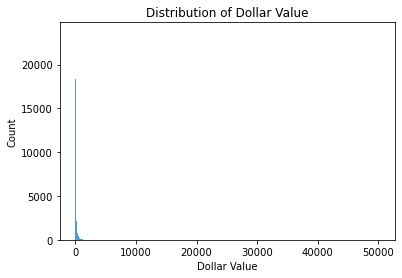

In [39]:
import seaborn as sns
sns.histplot(subsample['dollar_value'])
plt.title('Distribution of Dollar Value')
plt.xlabel('Dollar Value')

Text(0.5, 0, 'log(Dollar Value)')

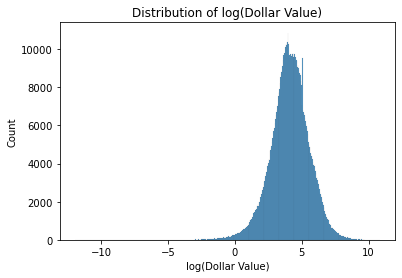

In [40]:
sns.histplot(np.log(subsample['dollar_value']))
plt.title('Distribution of log(Dollar Value)')
plt.xlabel('log(Dollar Value)')

### Solution - Outlier Detection and Removal

Extremely positive-skewed data. We attempt the rule-of-thumb outlier detection method $1.5\times IQR$ and check how much was removed.

In [41]:
lwr, upr = transaction.approxQuantile('dollar_value', [0.25, 0.75], 0)
iqr = upr - lwr
lwr_bound = lwr - 1.5 * iqr
upr_bound = upr + 1.5 * iqr

In [42]:
(lwr_bound, upr_bound)

(-160.33329721252636, 336.87985438863166)

Not a good outlier detection range (unrealistic lower bound, highly plausible upper bound), likely due to the highly skewed distribution of `dollar_value`.

In [43]:
transaction = transaction.withColumn('log(dollar_value)',
                                     F.log(F.col('dollar_value')))

In [44]:
lwr, upr = transaction.approxQuantile('log(dollar_value)', [0.25, 0.75], 0)
iqr = upr - lwr
lwr_bound = lwr - 1.5 * iqr
upr_bound = upr + 1.5 * iqr

In [45]:
lwr_bound, upr_bound = np.exp(lwr_bound), np.exp(upr_bound)

In [46]:
lwr_bound, upr_bound

(1.8902584230911532, 2078.7342190771465)

Much better outlier range, likely due to a more symmetric and normal distribution after taking the log of `dollar_value`. Comparable to the upper bound with the industry leading competitor (Afterpay) which has a maximum limit per transaction of $1500.

In [47]:
new_transaction = transaction.where(
    (F.col('dollar_value') >= lwr_bound) &
    (F.col('dollar_value') <= upr_bound)
)

In [48]:
subsample_2 = (new_transaction.sample(0.2)
                              .select(['dollar_value','order_id'])
                              .toPandas()
               )

Text(0.5, 0, 'Dollar Value')

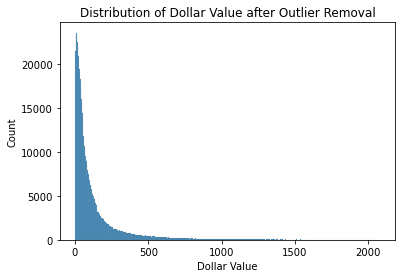

In [49]:
sns.histplot(subsample_2['dollar_value'])
plt.title('Distribution of Dollar Value after Outlier Removal')
plt.xlabel('Dollar Value')

Text(0.5, 0, 'log(Dollar Value)')

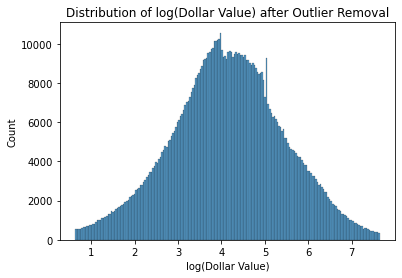

In [50]:
sns.histplot(np.log(subsample_2['dollar_value']))
plt.title('Distribution of log(Dollar Value) after Outlier Removal')
plt.xlabel('log(Dollar Value)')

In [51]:
pre_removal = transaction.count()
post_removal = new_transaction.count()
print(f"Number of instances after outlier removal: {post_removal}",
      f"\nNumber of outliers removed: {pre_removal - post_removal}",
      f"\n% data removed: {((pre_removal - post_removal)/pre_removal)*100:.2f}%")

Number of instances after outlier removal: 4407823 
Number of outliers removed: 100283 
% data removed: 2.22%


Much better outlier range. Distribution of `dollar_value` is still highly positive-skewed but that is just the nature of the data. The log(`dollar_value`) transformation improved the skewness overall.

### Other Findings: 
### Some merchants have high but inconsistent monthly revenue
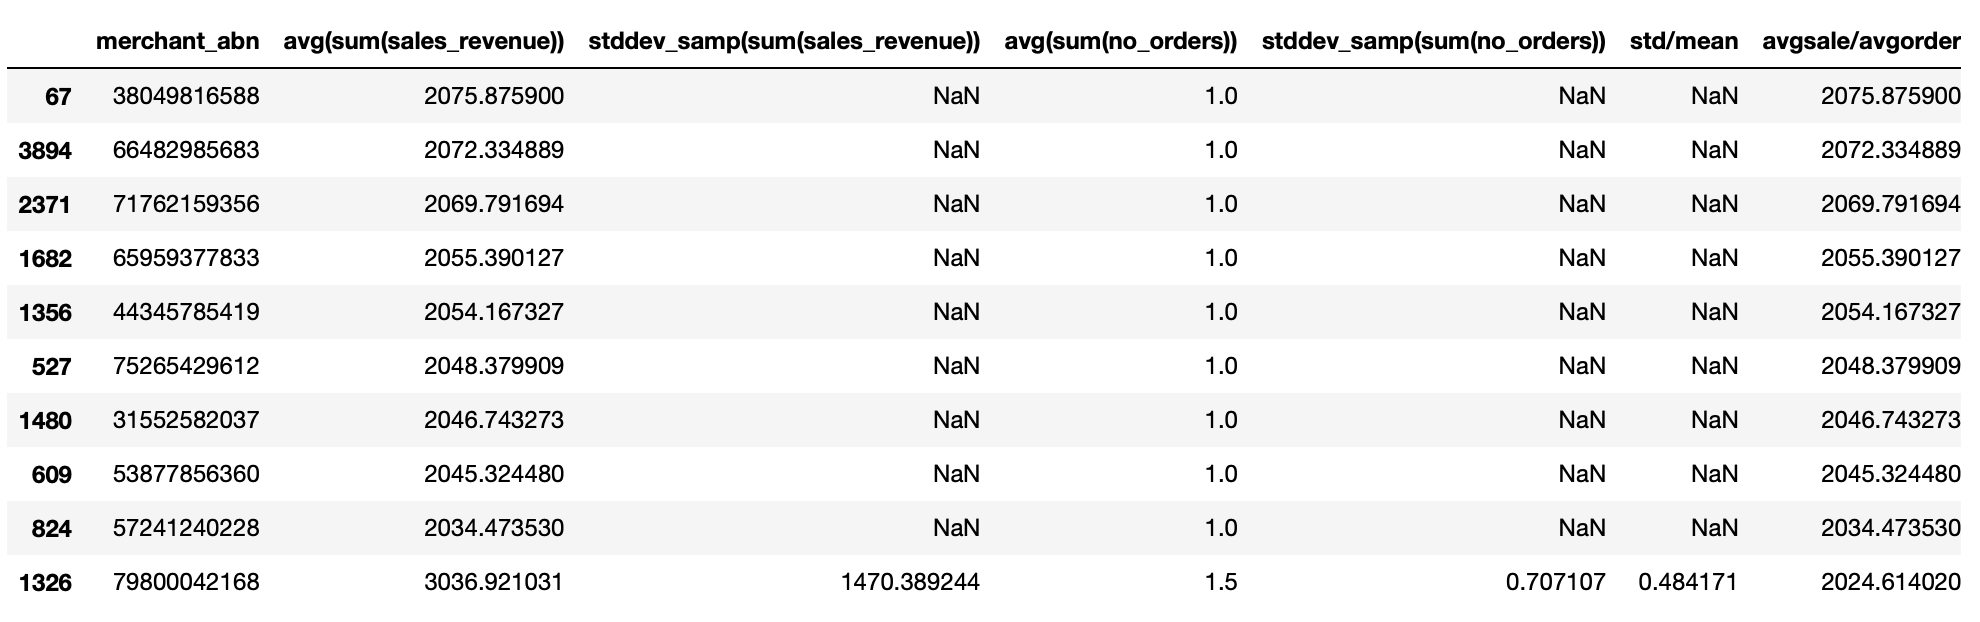

The table shows the average and standard deviation of the merchants' monthly revenue. Notice some merchants have inconsistent but high value transactions. Thus, we believe that it is important to include the consistency of merchant's monthly revenue as part of our ranking metrics.


### Some merchants have high transaction value per order
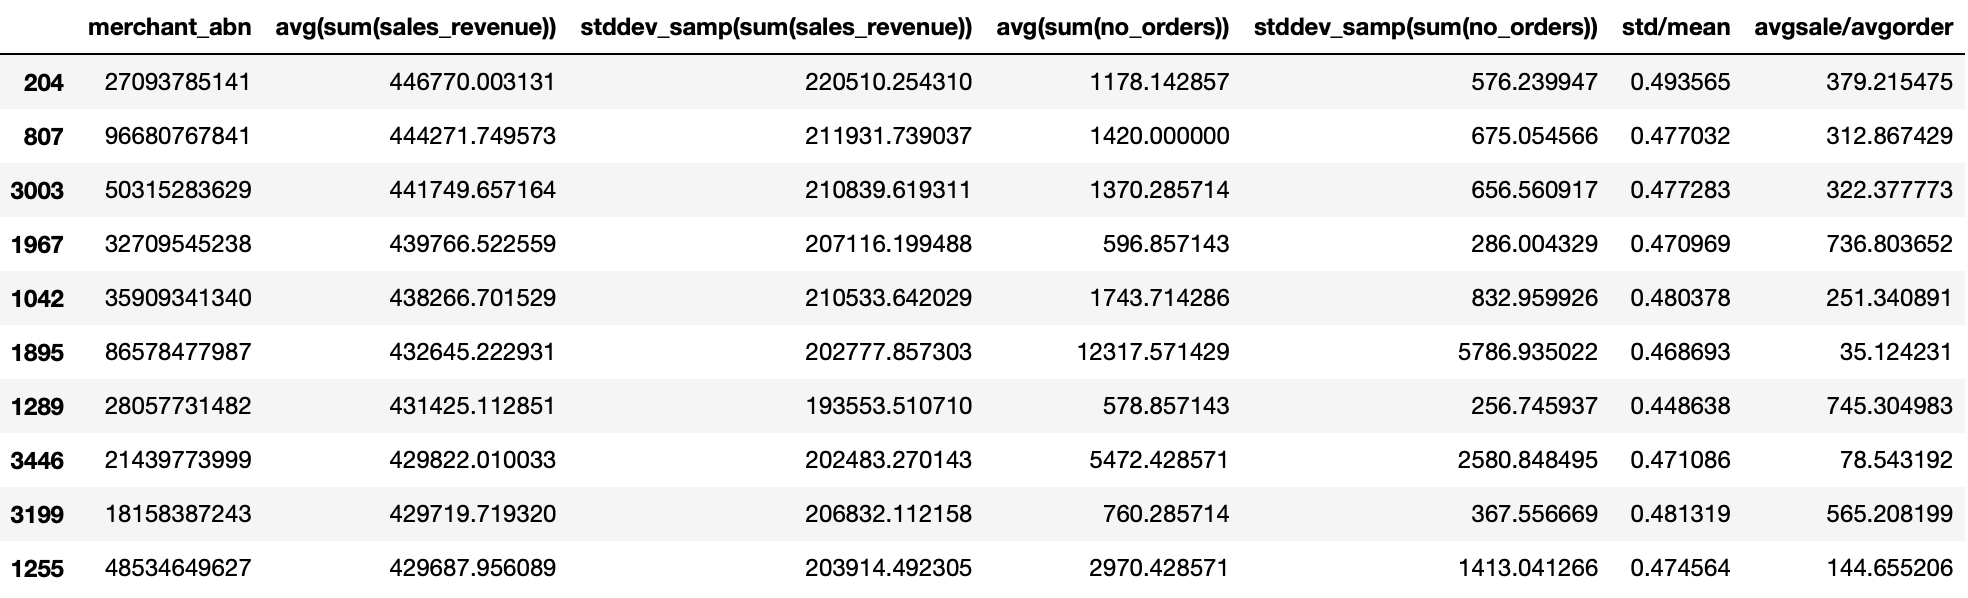


Notice the difference on average transaction per order between merchants despite having similar average revenue per month. Since different merchants have different take rate per transaction, we believe this will be very important in ranking merchants as we want to know how much we will be receiving on average per transaction from a merchant.

### Work in progress: Geospatial Visualization

Due to the constant crashing, we were not able to plot other results on time. The following is the total spending by Statistical Area 2 code.

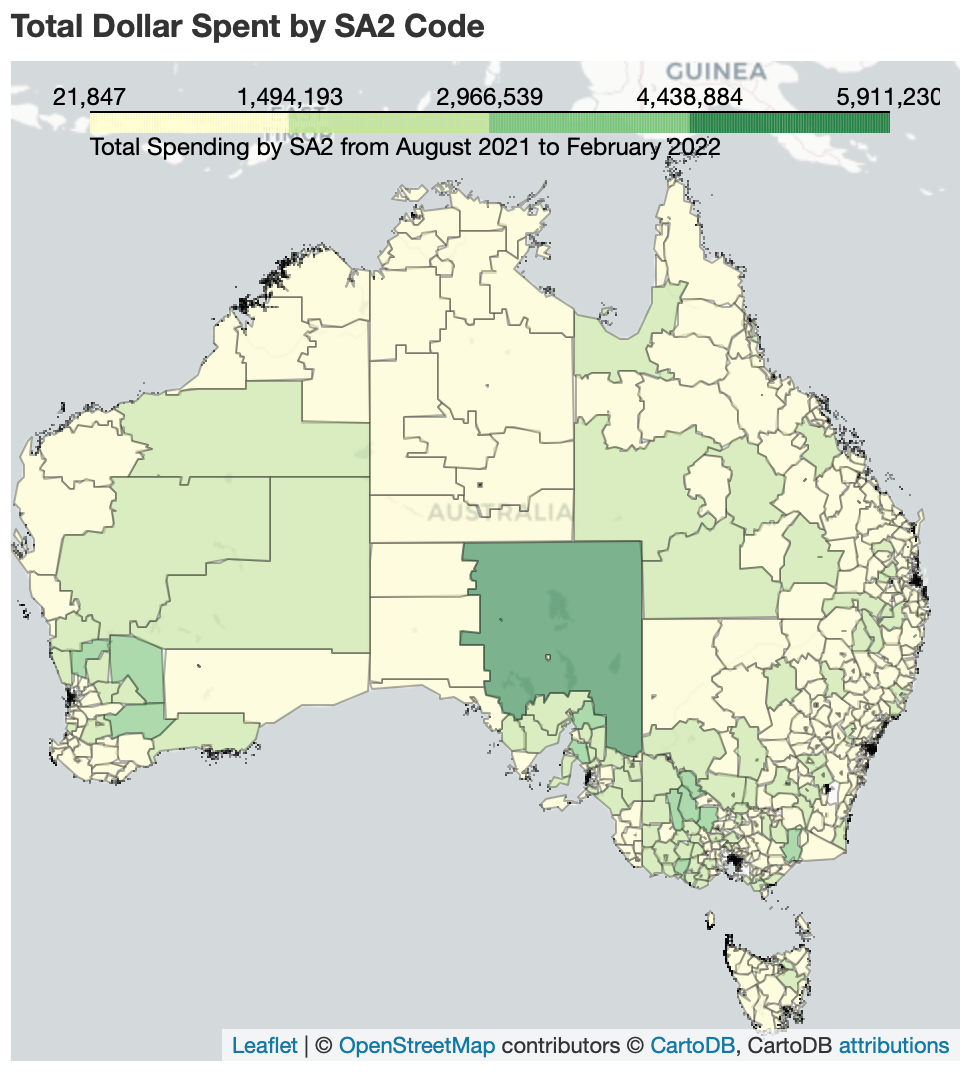

We may reduce the granularity by using SA3/4 codes instead when plotting other results in the future to avoid the constant crashing.


### How we will be using the external dataset:

### Merchant-specific

- ### Counting the number of SA2 regions that merchant sells to
- ### Weighing the regions based on average weekly personal income
- ### Combine these information as a single metric for each merchant


### Customer-specific
- ### Rating customers by repeat purchases, fraudulent rate, average personal weekly income
- ### Count number of "good" customer for each merchants